# 06. PyTorch Transfer Learning Exercises

## Resources

These exercises are based on https://www.learnpytorch.io/06_pytorch_transfer_learning/

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

from torchinfo import summary

In [2]:
from src import setup_data, engine

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Get data

In [4]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
        std=[0.229, 0.224, 0.225] # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
    ),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
    batch_size=32 # set mini-batch size to 32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x117a3c590>,
 ['pizza', 'steak', 'sushi'])

### 3. Get and prepare a pretrained model

In [7]:
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
model_0

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Freeze all bease layers in the "features" section of the model
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set manual seed
torch.manual_seed(42)

# Get the length of class names
output_shape = len(class_names)

# Recreate classifier layer and seed it to the taregt device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)
).to(device)

### 4. Train model

In [10]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=0.001,
)

In [11]:
# Set the random seeds
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0963 | train_acc: 0.3984 | test_loss: 0.8911 | test_acc: 0.5994
Epoch: 2 | train_loss: 0.9282 | train_acc: 0.6406 | test_loss: 0.7570 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.7683 | train_acc: 0.8594 | test_loss: 0.6671 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.7188 | train_acc: 0.7148 | test_loss: 0.5864 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.7121 | train_acc: 0.7305 | test_loss: 0.6075 | test_acc: 0.8977
[INFO] Total training time: 227.714 seconds


### 5. Make predictions on the entire test dataset with the model

In [12]:
from tqdm.auto import tqdm

def predict(
    model: torch.nn.Module,
    test_dataloader: torch.utils.data.DataLoader,
    device: str,
):
    results = []
    
    # Create random seed
    torch.manual_seed(42)
    
    # Put model to target device
    model = model.to(device)

    # Turn on eval mode
    model.eval()
    
    # Turn on inference mode
    with torch.inference_mode():
        # Iterate through batches:
        for X, _ in tqdm(test_dataloader):
            X = X.to(device)
            
            logits = model(X)
            
            pred_probs = torch.softmax(logits, dim=1)
            
            pred_labels = torch.argmax(pred_probs, dim=1)
            
            results.append(pred_labels)
    
    tensor_results = torch.cat(results).cpu()
    
    return tensor_results


In [13]:
preds = predict(
    model=model_0,
    test_dataloader=test_dataloader,
    device=device,
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
preds

tensor([1, 1, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1, 2, 1, 0, 2,
        0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 2, 1, 2, 1, 0, 2, 2, 1, 2, 1, 0, 2, 2, 1,
        0, 0, 0, 0, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 0, 2,
        2, 1, 0])

### 6. Make a confusion matrix with the test preds and the truth labels

In [15]:
import torchmetrics, mlxtend

print(mlxtend.__version__)

0.23.4


In [16]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass",
)

In [17]:
target = torch.cat(
    [y for X, y in test_dataloader]
)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [18]:
confmat_tensor = confmat(
    preds=preds,
    target=target
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

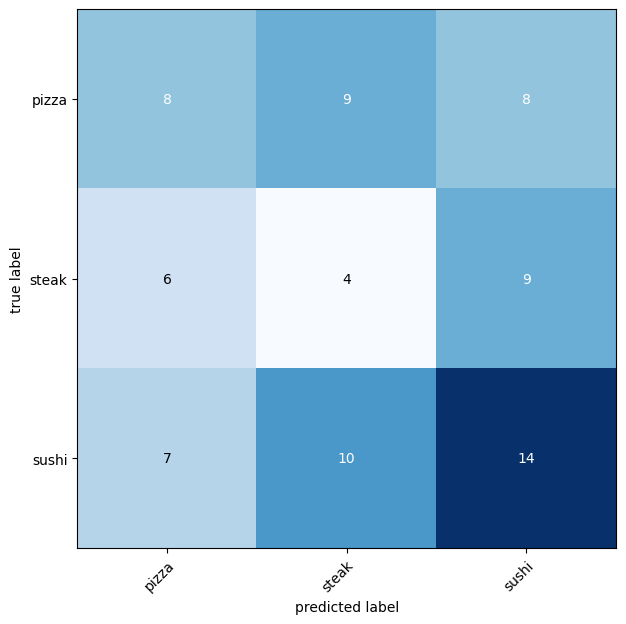

In [19]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)